In [3]:
!pip install yfinance seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 470.2 kB/s eta 0:00:000:00:010:00:01:01


In [5]:
# Yahoo Finance is used for data fetching
import yfinance as yf

# Pandas and numpy are used fir data manipulation
import pandas as pd
import numpy as np

#matplotlib and seaborn are used for plotting graph
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('seaborn-darkgrid')
import seaborn as sns

In [7]:
# Read the data
data = yf.download('BTC-USD', '2014-01-01', '2023-03-18', auto_adjust=True)
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-03-13,22156.406250,24550.837891,21918.199219,24197.533203,49466362688
2023-03-14,24201.765625,26514.716797,24081.183594,24746.074219,54622230164
2023-03-15,24770.925781,25240.615234,23964.910156,24375.960938,43655701450
2023-03-16,24373.457031,25190.326172,24225.111328,25052.789062,33866061747
2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,50730261335


In [8]:
data.describe()

,Open,High,Low,Close,Volume
count,3104.000000,3104.000000,3104.000000,3104.000000,3.104000e+03
mean,13078.141916,13406.026393,12716.766540,13085.296292,1.656704e+10
std,16055.367766,16465.483978,15584.084166,16052.353244,1.983295e+10
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06
25%,705.138992,715.932526,699.104752,705.045761,1.105555e+08
50%,7309.567627,7458.057129,7165.897949,7316.765137,8.683647e+09
75%,18536.928223,18959.987793,17940.926270,18549.029297,2.811283e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11


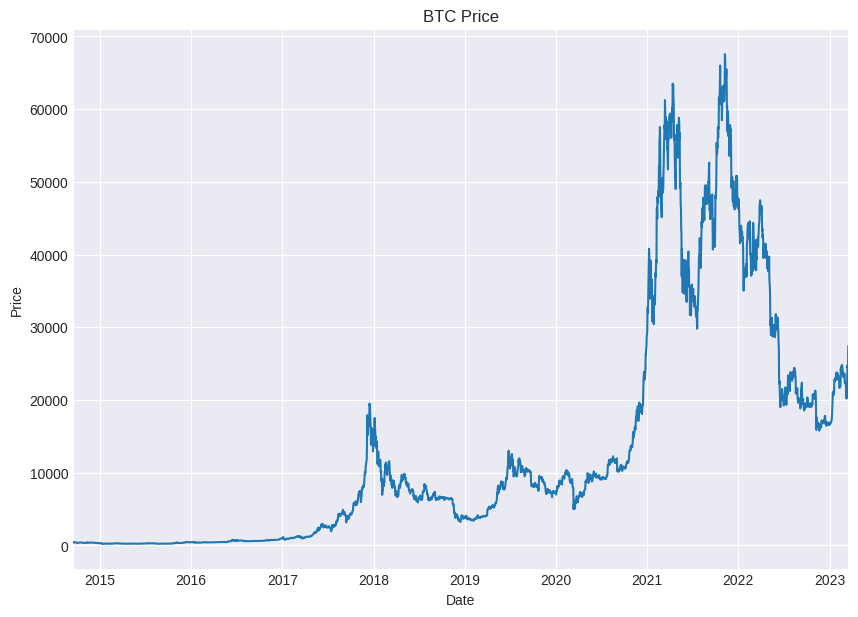

In [9]:
# PLot BTC Price Graph
data['Close'].plot(figsize=(10, 7))
plt.title('BTC Price')
plt.ylabel('Price')
plt.show()

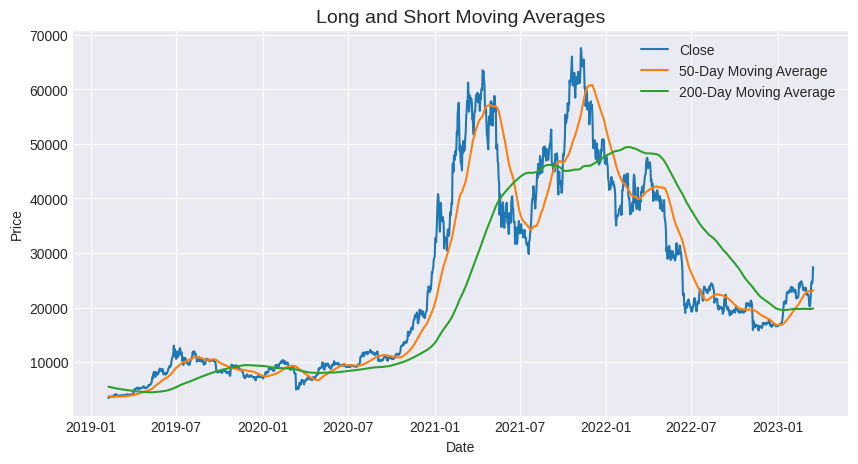

In [13]:
# Define long and short window
short_window = 50
long_window = 200

# Calculate moving averages
data['short_mavg'] = data['Close'].rolling(short_window).mean()
data['long_mavg'] = data['Close'].rolling(long_window).mean()

# Plot close price and moving averages
plot_data = data[-1500:]
plt.figure(figsize=(10, 5))
plt.title('Long and Short Moving Averages', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(plot_data['Close'], label='Close')
plt.plot(plot_data['short_mavg'], label='50-Day Moving Average')
plt.plot(plot_data['long_mavg'], label='200-Day Moving Average')

plt.legend()

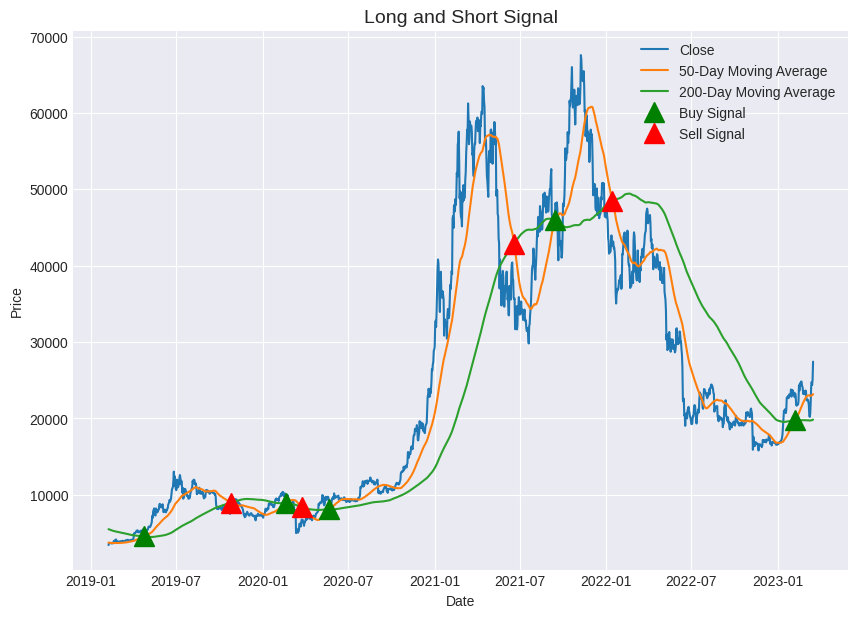

In [16]:
# Take long positions
data['long_positions'] = np.where(data['short_mavg'] > data['long_mavg'], 1, 0)

# Take short positions
data['short_positions'] = np.where(data['short_mavg'] < data['long_mavg'], -1, 0)

data['positions'] = data['long_positions'] + data['short_positions']

# Plot close price and moving averages
plot_data = data[-1500:]
plt.figure(figsize=(10, 7))
plt.title('Long and Short Signal', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(plot_data['Close'], label='Close')
plt.plot(plot_data['short_mavg'], label='50-Day Moving Average')
plt.plot(plot_data['long_mavg'], label='200-Day Moving Average')

plt.plot(plot_data[(plot_data['long_positions'] == 1) &
                  (plot_data['long_positions'].shift(1) == 0)]['short_mavg'],
        '^', ms=15, label='Buy Signal', color='green')

plt.plot(plot_data[(plot_data['short_positions'] == -1) &
                  (plot_data['short_positions'].shift(1) == 0)]['short_mavg'],
        '^', ms=15, label='Sell Signal', color='red')

plt.legend()
plt.show()

In [17]:
# Count unique values
unique, counts = np.unique(np.where(data['short_mavg'] > data['long_mavg'], 1, 0),
                          return_counts=True)
dict(zip(unique, counts))

{0: 1384, 1: 1720}

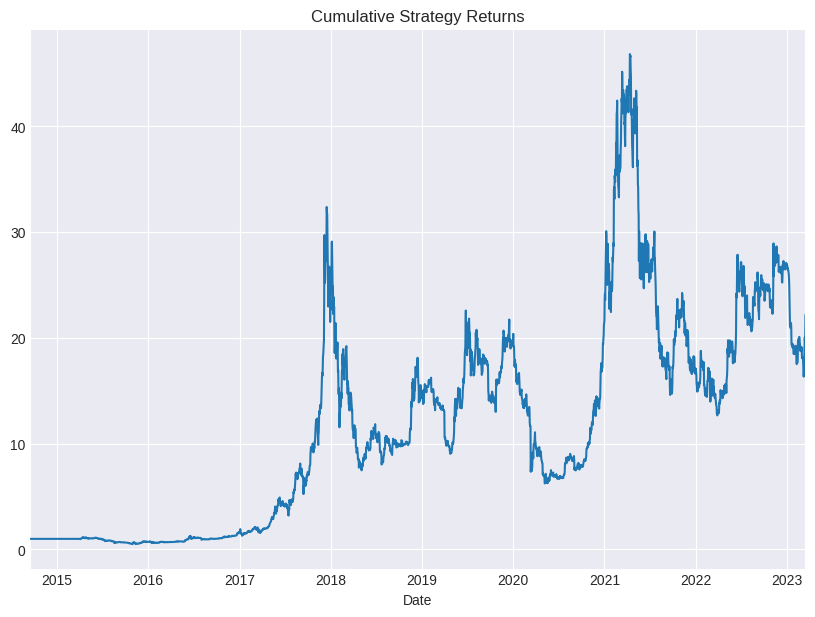

In [18]:
# Calculate daily returns
data['returns'] = data['Close'].pct_change()

# Calculate strategy returns
data['strategy_returns'] = data['returns'] * data['positions'].shift(1)

# Plot cumulative returns
cumulative_returns = (data['strategy_returns'] + 1).cumprod()
cumulative_returns.plot(figsize=(10, 7))
plt.title('Cumulative Strategy Returns')
plt.show()

In [19]:
# Total number of trading days
days = len(cumulative_returns)

# Calculate compounded annual growth rate
annualised_returns = (cumulative_returns.iloc[-1]**(365/days)-1)*100

# Calculate annualised volatility
annualised_volatility = np.std(data.strategy_returns)*(365**0.5)*100

# Assume an average annual risk-free rate is 1%
risk_free_rate = 0.01/365

sharpe_ratio = np.sqrt(365)*(np.mean(data.strategy_returns) - 
                            (risk_free_rate))/np.std(data.strategy_returns)

# Calculate the running maximum
running_max = np.maximum.accumulate(cumulative_returns.dropna())

# Ensure the value never drops below 1
running_max[running_max < 1] = 1

# Calculate the percentage drawdown
drawdown = (cumulative_returns)/running_max - 1
max_dd = drawdown.min()*100

print('The annualised returns of strategy is %.2f' % annualised_returns + '%')
print('The annualised volatility of strategy is %.2f' % annualised_volatility + '%')
print('The risk free rate is %.2f' % risk_free_rate)
print('The sharpe ratio is %.2f' % sharpe_ratio)
print('The percentage drawdown is %.2f' % max_dd + '%')

The annualised returns of strategy is 43.99%
The annualised volatility of strategy is 69.97%
The risk free rate is 0.00
The sharpe ratio is 0.86
The percentage drawdown is -80.74%
